#### Подготовительные мероприятия

In [1]:
import pandas as pd
import datetime
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
path = 'c:/Users/stavr/Downloads/Test_sample.csv'

In [3]:
df = pd.read_csv(path, sep='~')

#### Предобработка

In [4]:
df_0 = df.copy()

In [28]:
# создали дф для подсчета продаж
df_sale = df_0.sort_values(by=['id','time'])
df_sale['sale_id'] = 0
df_sale['flag_id'] = 0
df_sale['sum_sale'] = 0
df_sale.reset_index()
df_sale.head(3)

,Unnamed: 0,time,id,title,brand_id,brand_name,price_base,price_final,price_discount,rating_value,...,is_personalized,is_promoted_product,is_new,is_bestseller,in_stock,session_id,data_source,sale_id,flag_id,sum_sale
325829,325829,2021-07-14 21:15:13+03:00,7317851,D-Link DES-1008D/RU коммутатор,26303099,D-Link,1140.0,1140,0.0,0.0,...,0,0,0,0,5,1626278536,python-v2.0,0,0,0
325830,325830,2021-07-14 23:57:06+03:00,7317851,D-Link DES-1008D/RU коммутатор,26303099,D-Link,1150.0,1150,0.0,0.0,...,0,0,0,0,5,1626289336,python-v2.0,0,0,0
268216,268216,2021-07-15 18:57:25+03:00,7317851,D-Link DES-1008D/RU коммутатор,26303099,D-Link,1150.0,1150,0.0,0.0,...,0,0,0,0,5,1626354136,python-v2.0,0,0,0


In [6]:
#2 Посчитаем продажи (вычислим разницу остатков до сессии и после сессии)
# сдвинем колонку остатков вниз, вычтем из остатков сдвинутый столбец и вернем результаты снова вверх 
# в качестве флага подтянем номер id товара (по нему будем проверять прежде чем считать продажу)
df_sale['_slide_stock'] = df_sale['in_stock'].shift(1, fill_value=0)
df_sale['flag_id'] = df_sale['id'].shift(1, fill_value=0)

df_sale.loc[df_sale['id'] == df_sale['flag_id'], 'sale_id'] = (df_sale.in_stock - df_sale._slide_stock) 
df_sale['sale_id'] = df_sale['sale_id'].shift(-1, fill_value=0) # сдвигаем к дате сессии
# df_sale

In [7]:
# введем признак, определяющий сумму продажи:
df_sale.loc[df_sale['sale_id'] < 0, 'sum_sale'] = df_sale.price_final * df_sale.sale_id * (-1)

In [8]:
# Выручка за мес.
total_sum = df_sale.sum_sale.sum()/1000000
print(f' Выручка за мес.(млн.) = {total_sum}')


 Выручка за мес.(млн.) = 2034.479256


#### Task_1 Рассчитать продажи за день по каждому товару

In [9]:
df_sale_day = df_sale[['time', 'id', 'title', 'brand_id', 'brand_name',
                      'price_final', 'in_stock','session_id', 'data_source', 'sale_id', 'sum_sale']]

In [10]:
df_sale_day.head(3)

,time,id,title,brand_id,brand_name,price_final,in_stock,session_id,data_source,sale_id,sum_sale
325829,2021-07-14 21:15:13+03:00,7317851,D-Link DES-1008D/RU коммутатор,26303099,D-Link,1140,5,1626278536,python-v2.0,0,0
325830,2021-07-14 23:57:06+03:00,7317851,D-Link DES-1008D/RU коммутатор,26303099,D-Link,1150,5,1626289336,python-v2.0,0,0
268216,2021-07-15 18:57:25+03:00,7317851,D-Link DES-1008D/RU коммутатор,26303099,D-Link,1150,5,1626354136,python-v2.0,0,0


In [11]:
# преобразуем формат поля time в дату-время (новый признак _time_d)
df_sale_day['_time_d'] = pd.to_datetime(df_sale_day['time'], format="%Y/%m/%d %H:%M:%S")
# (получим новый признак даты _day)
df_sale_day['_day'] = pd.DatetimeIndex(df_sale_day['_time_d']).day

In [12]:
df_sale_day.head(2)

,time,id,title,brand_id,brand_name,price_final,in_stock,session_id,data_source,sale_id,sum_sale,_time_d,_day
325829,2021-07-14 21:15:13+03:00,7317851,D-Link DES-1008D/RU коммутатор,26303099,D-Link,1140,5,1626278536,python-v2.0,0,0,2021-07-14 21:15:13+03:00,14
325830,2021-07-14 23:57:06+03:00,7317851,D-Link DES-1008D/RU коммутатор,26303099,D-Link,1150,5,1626289336,python-v2.0,0,0,2021-07-14 23:57:06+03:00,14


In [13]:
# выручка за 01.07.2021 
df_sale_day.loc[df_sale_day['_day'] == 1].sum_sale.sum()

164450254

In [30]:
# Можно выбросить из рассмотрения сесси без продаж (полностью строку сессии), но тогда мы сократим объем данных 
# поэтому Рассчитывать продажи за день по каждому товару будем с учетом непроданных товаров.

# df_sale_day = df_sale_day.loc[df_sale_day['sum_sale'] != 0] # для расчета только купленных позиций - снять кометарий

# 1. Рассчитать продажи за день по каждому товару
task_1 = df_sale_day.groupby(['_day', 'id']).sum_sale.sum()
task_1_df = pd.DataFrame(df_sale_day.groupby(['_day', 'id']).sum_sale.sum())
task_1_df.head(4)

sum_sale
_day id               
1    7317861       818
     7317867      1344
     7317901      1070
     7317902       590

#### Task_2 Выявить топ 10 брендов по выручке, топ 10 продаваемых товаров

In [15]:
df_sale_brand = df_sale[['time', 'id', 'title', 'brand_id', 'brand_name',
                      'price_final', 'in_stock','session_id', 'data_source', 'sale_id', 'sum_sale']]

In [16]:
# посчитаем пропуски в наименовании бренда
df_sale_brand.brand_name.isna().sum()
print(f'В датафрейме в поле "brand_name" пропущено {round((df_sale_brand.brand_name.isna().sum()/df_sale_brand.shape[0])*100,2)}% данных')

В датафрейме в поле "brand_name" пропущено 7.95% данных


In [17]:
# заменим пропуски в наименовании бренда на "Noname"
df_sale_brand.loc[df_sale_brand['brand_name'].isna(), 'brand_name'] = 'Noname'
# df_sale_brand.loc[df_sale_brand.brand_name == 'Noname']

In [31]:
# Определим топ 10 брендов по выручке
task_2_a = pd.DataFrame(df_sale_brand.groupby(['brand_name']).sum_sale.sum().sort_values(ascending=False).head(10))
task_2_a.head(4)

,sum_sale
brand_name,
MIKROTIK,324360345
UBIQUITI,230695188
TP-Link,168489843
D-Link,149216268


In [32]:
# Определим топ 10 товаров по выручке 
task_2_b = pd.DataFrame(df_sale_brand.groupby(['title', 'id']).sum_sale.sum().sort_values(ascending=False).head(10))
task_2_b.head(4)

,,sum_sale
title,id,
Коммутатор UBIQUITI US-48-500W,277935653,44137365
Ubiquiti Networks UniFi Dream Machine Pro Управляемый Gigabit Ethernet (10/100/1000) Белый UDM-PRO,278288884,35721135
Коммутатор (switch) MikroTik CRS354-48P-4S+2Q+RM (CRS354-48P-4S+2Q+RM),207507755,29901991
Точка доступа MIKROTIK RBD53iG-5HacD2HnD,229486865,28374242


#### Task_3 Выявить топ товаров, приносящих 80% выручки

In [20]:
df_sale_top = df_sale[['time', 'id', 'title', 'brand_id', 'brand_name',
                      'price_final', 'in_stock','session_id', 'data_source', 'sale_id', 'sum_sale']]

In [21]:
# общая выручка (так, для интереса)
total_sum = df_sale_top.groupby(['id']).sum_sale.sum().sum()
print('Общая выручка = ', total_sum)

Общая выручка =  2034479256


In [22]:
# расположим в порядке убывания id товаров и суммы их продаж 
df_id_total_sum = pd.DataFrame(df_sale_top.groupby(['id']).sum_sale.sum().sort_values(ascending=False))

In [23]:
# определим квантиль 0.8 и по нему отделим id, дающие 80% выручку 
quants = [0.8] 
q = df_id_total_sum.quantile(quants).iloc[0,0]
q

22444.600000000028

In [24]:
# отберем id, которые вошли в квантиль 0,8 (выполнили 80% выручки)
task_3 = pd.DataFrame(df_id_total_sum.loc[df_id_total_sum.sum_sale > q].index)
print(f'Топ товаров, приносящих 80% выручки, состоит из {len(task_3)} позиций: \n\n{task_3}')

Топ товаров, приносящих 80% выручки, состоит из 4972 позиций: 

             id
0     277935653
1     278288884
2     207507755
3     229486865
4     278103109
...         ...
4967  224617239
4968  292938854
4969  241527060
4970  287204931
4971  173274158

[4972 rows x 1 columns]


#### Task_4 Построить график продаж от времени (опционально)

In [25]:
# График продаж по датам
task_5 = df_sale_day.groupby('_day').sum_sale.sum()
task_5 = round(task_5/1000000, 2)
task_5 = pd.DataFrame(task_5)
# task_5.sum_sale

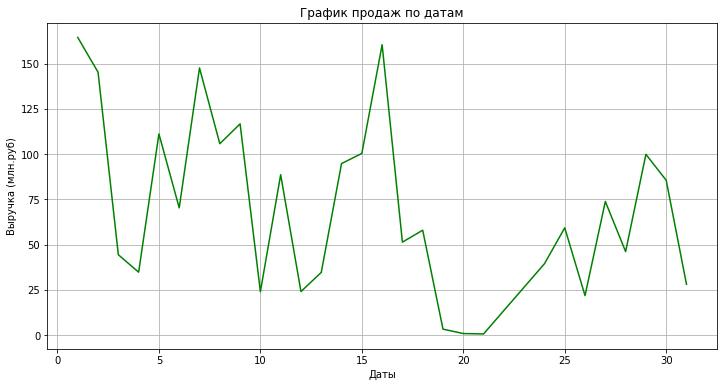

In [26]:
# Построение графика
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(task_5,  'g')
plt.title('График продаж по датам') 
plt.xlabel('Даты') # ось абсцисс
plt.ylabel('Выручка (млн.руб)') # ось ординат
plt.grid()  
plt.show()

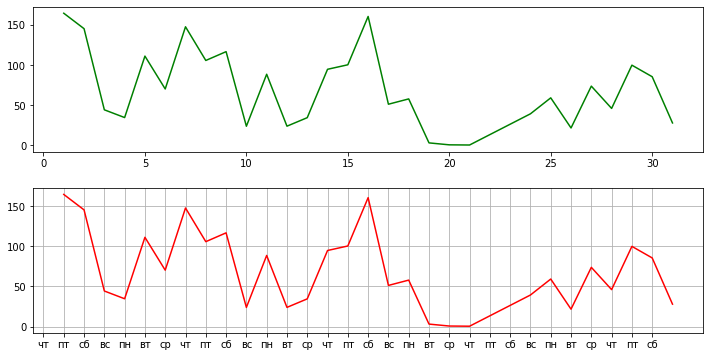

In [43]:
# Построение графика
fig, ax = plt.subplots(nrows=2, ncols=1)
fig.set_size_inches(12, 6)
fig.subplots_adjust(hspace=0.25)
ax[0].plot(task_5,  'g')
plt.grid() 
ax[1].plot(task_5,  'r')
plt.xticks(range(31), ['чт', 'пт', 'сб', 'вс', 
                  'пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс', 
                  'пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс',
                  'пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс',
                   'пн', 'вт', 'ср','чт', 'пт', 'сб'  ]),

plt.show()


In [44]:
df_sale_day.head(2)

,time,id,title,brand_id,brand_name,price_final,in_stock,session_id,data_source,sale_id,sum_sale,_time_d,_day
325829,2021-07-14 21:15:13+03:00,7317851,D-Link DES-1008D/RU коммутатор,26303099,D-Link,1140,5,1626278536,python-v2.0,0,0,2021-07-14 21:15:13+03:00,14
325830,2021-07-14 23:57:06+03:00,7317851,D-Link DES-1008D/RU коммутатор,26303099,D-Link,1150,5,1626289336,python-v2.0,0,0,2021-07-14 23:57:06+03:00,14


In [45]:
# (получим новый признак даты _час)
df_sale_day['_hour'] = pd.DatetimeIndex(df_sale_day['_time_d']).hour

In [46]:
task_5_hour = df_sale_day.groupby('_hour').sum_sale.sum()
task_5_hour = round(task_5_hour/1000000, 2)
task_5_hour

_hour
0     108.45
1      88.45
2     101.06
3     113.00
4      32.58
5      37.72
6      72.08
7      48.31
8      87.47
9     244.89
10    130.42
11     62.11
12    123.88
13    108.67
14     82.58
15     64.06
16     14.66
17     74.91
18     96.76
19     60.35
20    115.12
21     58.77
22     34.56
23     73.62
Name: sum_sale, dtype: float64

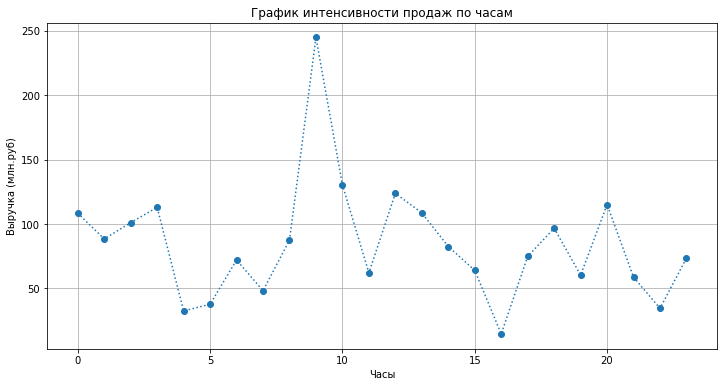

In [47]:
fig, ax = plt.subplots(figsize=(12, 6))

plt.plot(task_5_hour,  ':o')
plt.title('График интенсивности продаж по часам') 
plt.xlabel('Часы') 
plt.ylabel('Выручка (млн.руб)') 

plt.grid()  
plt.show()

 <font size=3 color=red>  **Пик продаж 9 утра**

In [48]:
# (получим новый признак даты _weekday)
df_sale_day['_weekday'] = pd.DatetimeIndex(df_sale_day['_time_d']).weekday

In [49]:
task_5_week = df_sale_day.groupby('_weekday').sum_sale.sum()
task_5_week = round(task_5_week/1000000, 2)

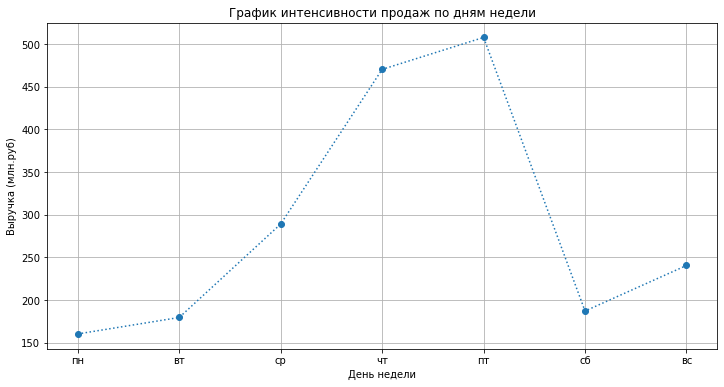

In [51]:
fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(task_5_week,  ':o')
plt.title('График интенсивности продаж по дням недели') 
plt.xlabel('День недели') 
plt.ylabel('Выручка (млн.руб)') 
plt.grid()  
plt.xticks(range(7), ['пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс'])

plt.show()

 <font size=3 color=red> **Наибольшие покупки - четверг, пятница**

#### Task_5 Оценить качество данных

In [52]:
# Пропуски в brand_name = 85456  seller_name  = 10821 
df.isna().sum()                     

Unnamed: 0                  0
time                        0
id                          0
title                       0
brand_id                    0
brand_name              85456
price_base                  0
price_final                 0
price_discount              0
rating_value                0
rating_count                0
index                       0
page_number                 0
search_filter               0
category_id                 0
category_name               0
category_count_pages        0
category_count_items        0
category_path               0
category_root_name          0
category_lvl1_name          0
category_lvl2_name          0
delivery_schema             0
availability                0
seller_id                   0
seller_name             10821
is_redirect                 0
is_premium_only             0
is_adult                    0
is_alcohol                  0
is_supermarket              0
is_personalized             0
is_promoted_product         0
is_new    

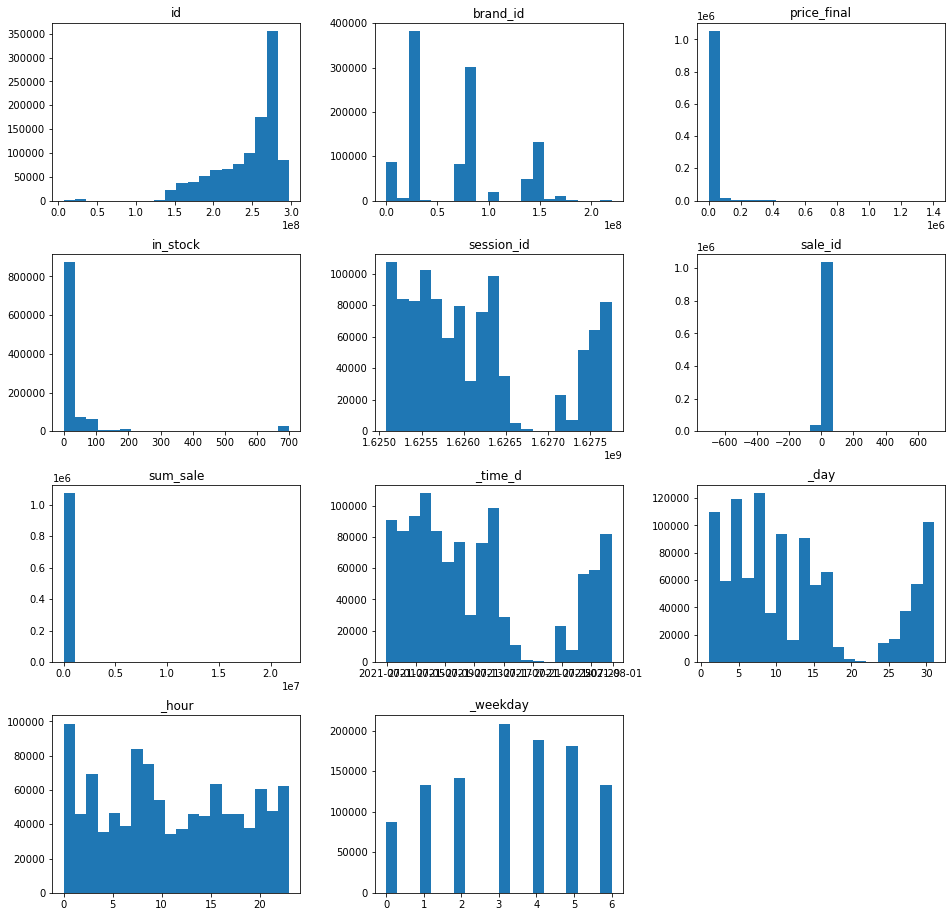

In [53]:
# Выбросы (судя по гистограммам session_id и _day - наблюдается провал в данных за 20..25 число) СБОЙ в БД
df_sale_day.hist(figsize=(16,16), bins=20, grid=False);

In [54]:
# Некорректные значения в ОСТАТКАХ
df_x = df.loc[df.in_stock <0]
df_x.shape[0]

4164

In [55]:
df.shape[0]

1074749

#### Task_6 Объяснить полученную картину:
**падения и пики на графике продаж
как можно улучшить расчет продаж на текущих данных?**

**Очевидные пики и провалы** - активность пользователей по дням недели (кроме 20..25 - тут провал из-за битых данных)

**Как улучшить расчет продаж на текущих данных?**  - попробовать восстановить пропущенные/битые (в бренде и в остатках). Некорректных значений в ОСТАТКАХ 4164. Правда - это всего 0,5%, но все-таки
В брендах - 8% пропусков наименований, но восстановить попробовать.

<font size=3 color=green>
Общие вопросы:<br>


**1.Как будете заполнять пропущенные значения в данных?**
- Некорректные данные в остатках - заменить на 0
- Пропуски в сессиях 
  1 вариант (быстрый): восстановить средней медианой по имеющимся дням недели. 
  2 вариант (сложнее,медленнее, но может дать большую точность): Можно проанализировать номера сессий, в "хороших" днях - установить порядок нумерации сессий, далее по обрывкам номеров можно восстановить пропущенные сессии. Рассчитать средний чек сесии и применить его.
- brand_name   seller_name - не восстанавливал бы (зря время потратить)

**2.Что делать, если датасет несбалансированный?**
 - попробовать нормализовать
 

**3.Каковы потенциальные причины аномалий в наборе данных?**
 - Под аномалиями нонимаю провал в данных за 20..25. Причину вижу в сбое работы БД (была переустановка, наладка, обновление)
 

**4.Что делать, если данных не хватает или они плохого качества?**
- плохие данные на входе - плохие данные на выходе. 
- пытаться восстановить, что возможно.
- пытаться выжать все возможное из имеющихся: составить новые признаки по хорошим данным, в которых уверен (напимер проанализировать связь среднего чека